In [1]:
import json

import pandas as pd

with open('data/tickers.json', 'r') as f:
    tickers = json.load(f)

vwrl = tickers['IE00B3RBWM25']
df = pd.read_csv(f'data/IE00B3RBWM25-{vwrl}.csv', parse_dates=['Date'])
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
3111,2024-09-16 00:00:00+01:00,135.149994,135.509995,134.619995,135.139999,12083,0.0,0.0,0.0
3112,2024-09-17 00:00:00+01:00,135.779999,136.199997,135.669998,135.910004,10362,0.0,0.0,0.0
3113,2024-09-18 00:00:00+01:00,135.669998,135.820007,135.190002,135.199997,25748,0.0,0.0,0.0
3114,2024-09-19 00:00:00+01:00,136.899994,137.570007,136.673004,137.449997,15721,0.0,0.0,0.0
3115,2024-09-20 00:00:00+01:00,137.350006,137.899994,136.520004,136.600006,43344,0.0,0.0,0.0


<Axes: xlabel='Date'>

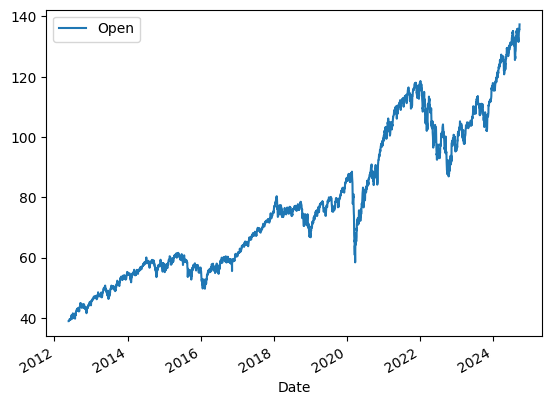

In [2]:
df.plot(x='Date', y=['Open'])

We use a very simple dollar cost averaging strategy

At the start of each month, we invest a set amount of cash. Using the total available cash, we buy as many equities as possible. This is a buy and hold strategy, we assume no selling.

Additionally, we simplify some aspects
- Dividends are not taken into account, we only look at the end return


In [10]:
import datetime

def backtest(df, cash=0, monthly_input=500, transaction_cost=1):
    total_expense = 0
    equity = 0
    equity_peak = 0
    transactions = []
    portfolio_worth = []
    
    metrics = {}
    
    metrics['start'] = df.iloc[0]['Date']
    metrics['end'] = df.iloc[-1]['Date']
    metrics['duration'] = metrics['end'] - metrics['start']
    
    current_month = None
    
    for row in df.to_dict(orient='records'):
    
        date = row['Date']

        # edge case, no data
        if row['Open'] == 0:
            continue
        
        # detect new month, assume data is in ascending order
        if date.month != current_month:
            current_month = date.month
    
            # buy using available cash
            cash += monthly_input
            total_expense += monthly_input
    
            to_buy = int((cash - transaction_cost) / row['Open'])
    
            cash = cash - transaction_cost - to_buy * row['Open']
            
            transactions.append((date, to_buy, row['Open'], cash))
            equity += to_buy
    
        portfolio_worth.append((date, equity, total_expense, equity * row['Open']))
        
        equity_high = equity * row['High']
        if equity_high > equity_peak:
            equity_peak = equity_high
    
    metrics['equity_peak'] = equity_peak
    metrics['equity_final'] = df.iloc[-1]['High'] * equity
    metrics['total_expense'] = total_expense
    metrics['BEP'] = total_expense / equity
    metrics['current'] = df.iloc[-1]['Open']
    metrics['unrealized_return'] = metrics['equity_final'] - total_expense
    metrics['unrealized_return_over_expense'] = ((metrics['equity_final'] - total_expense) / total_expense) * 100.0

    return metrics, transactions, portfolio_worth


metrics, transactions, portfolio_worth = backtest(df)
metrics

{'start': Timestamp('2009-01-05 00:00:00+0100', tz='UTC+01:00'),
 'end': Timestamp('2024-09-20 00:00:00+0200', tz='UTC+02:00'),
 'duration': Timedelta('5736 days 23:00:00'),
 'equity_peak': 130122.16125297546,
 'equity_final': np.float64(130122.16125297546),
 'total_expense': 94500,
 'BEP': 17.31720725673447,
 'current': np.float64(23.76499938964844),
 'unrealized_return': np.float64(35622.161252975464),
 'unrealized_return_over_expense': np.float64(37.69540873330737)}

/Users/nick/dev/degiro-etf-backtest/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/nick/dev/degiro-etf-backtest/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


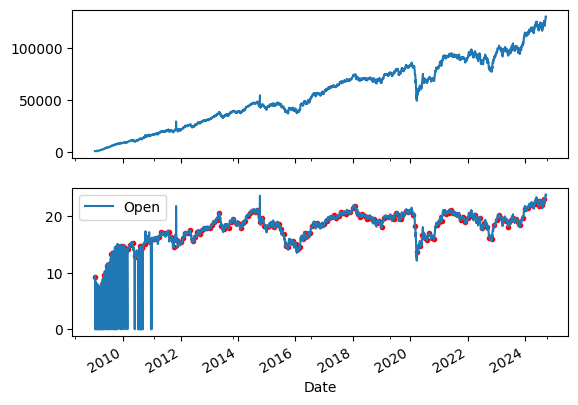

In [11]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, sharex=True)

axs[0].plot([r[0] for r in portfolio_worth], [r[3] for r in portfolio_worth])

df.plot(x='Date', y='Open', ax=axs[1])
axs[1].scatter([r[0] for r in transactions], [df.loc[df['Date'] == r[0]]['Open'] for r in transactions], c='red', marker='.')

In [20]:
import csv
from pathlib import Path

all_metrics = []

for isin, ticker in tickers.items():
    if not Path(f'data/{isin}-{ticker}.csv').is_file():
        continue

    df = pd.read_csv(f'data/{isin}-{ticker}.csv', parse_dates=['Date'])

    # XXX: empty data
    if len(df) == 0:
        continue

    metrics = {}
    metrics['ticker'] = ticker
    metrics['isin'] = isin
    
    m, _, _ = backtest(df)
    metrics.update(m)
    
    all_metrics.append(metrics)

df_all = pd.DataFrame(all_metrics)
df_all.to_csv('metrics.csv')
df_all

,ticker,isin,start,end,duration,equity_peak,equity_final,total_expense,BEP,current,unrealized_return,unrealized_return_over_expense
0,EUEAA.XC,IE0008471009,2022-11-10 00:00:00+00:00,2024-09-19 00:00:00+01:00,678 days 23:00:00,13036.399841,13020.800476,11500,44.230769,50.080002,1520.800476,13.224352
1,FXC.L,IE00B02KXK85,2009-01-02 00:00:00+00:00,2024-09-20 00:00:00+01:00,5739 days 23:00:00,101673.000000,69600.000000,94500,7875.000000,5782.000000,-24900.000000,-26.349206
2,ISF.L,IE0005042456,2009-01-02 00:00:00+00:00,2024-09-20 00:00:00+01:00,5739 days 23:00:00,121247.676732,118379.098206,94500,642.857143,803.500000,23879.098206,25.268887
3,IDVY.AS,IE00B0M62S72,2008-01-02 00:00:00+01:00,2024-09-20 00:00:00+02:00,6105 days 23:00:00,144303.111750,144033.590605,100500,12.678188,18.096001,43533.590605,43.317006
4,IAEX.AS,IE00B0M62Y33,2008-01-02 00:00:00+01:00,2024-09-20 00:00:00+02:00,6105 days 23:00:00,261473.751346,252125.604256,100500,36.034421,90.309998,151625.604256,150.871248
...,...,...,...,...,...,...,...,...,...,...,...,...
62,WCLD.L,IE00BJGWQN72,2019-09-03 00:00:00+01:00,2024-09-20 00:00:00+01:00,1844 days 00:00:00,29115.978546,28317.800690,30500,33.738938,31.150000,-2182.199310,-7.154752
63,FOOD.L,IE00BLRPQH31,2020-08-27 00:00:00+01:00,2024-09-20 00:00:00+01:00,1485 days 00:00:00,23026.501021,23026.501021,25000,4.668534,4.300000,-1973.498979,-7.893996
64,HTWO.L,IE00BMYDM794,2021-02-10 00:00:00+00:00,2024-09-20 00:00:00+01:00,1317 days 23:00:00,17768.879814,17231.148262,22000,5.765199,4.455000,-4768.851738,-21.676599
65,WCBR.L,IE00BLPK3577,2021-01-25 00:00:00+00:00,2024-09-20 00:00:00+01:00,1333 days 23:00:00,26589.450550,26109.609360,22500,21.448999,24.889999,3609.609360,16.042708
